In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Successfully loaded 'Original Model' from '/content/drive/MyDrive/ATML-PA3/TASK 1/vgg11_cifar10_finetuned.pth'
Successfully loaded 'Unstructured Pruned' from '/content/drive/MyDrive/ATML-PA3/TASK 1/unstructured_pruned_vgg11.pth'
Successfully inferred structured VGG config: [57, 'M', 102, 'M', 128, 102, 'M', 128, 102, 'M', 76, 51, 'M']
Rebuilding classifier with input features: 2499
Successfully loaded 'Structured Pruned' from '/content/drive/MyDrive/ATML-PA3/TASK 1/vgg11_cifar10_structured_pruned_CORRECT.pth'

Generating Grad-CAM for image index 25 (Actual Class: bird)


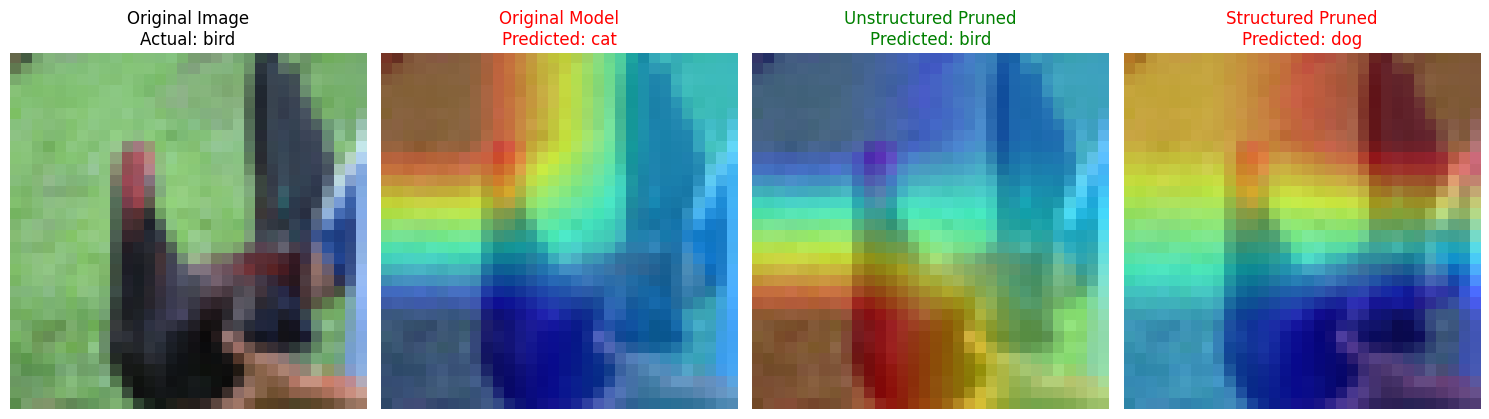

In [ ]:

from google.colab import drive
import os


drive.mount('/content/drive')

!pip install grad-cam -q


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11, VGG
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def create_vgg11_model():
    model = vgg11(weights=None)
  
    model.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 10),
    )
   
    model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    return model


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


def load_structured_pruned_model(path, device):
    state_dict = torch.load(path, map_location=device)

   
    conv_channels = []
    for key, value in state_dict.items():
        if "features" in key and "weight" in key and len(value.shape) == 4: 
            conv_channels.append(value.shape[0])

   
    cfg = [
        conv_channels[0], 'M',
        conv_channels[1], 'M',
        conv_channels[2], conv_channels[3], 'M',
        conv_channels[4], conv_channels[5], 'M',
        conv_channels[6], conv_channels[7], 'M'
    ]
    print(f"Successfully inferred structured VGG config: {cfg}")

 
    last_channel_size = conv_channels[-1]
    model = VGG(make_layers(cfg, batch_norm=False), num_classes=10)

 
    num_features = last_channel_size * 7 * 7
    print(f"Rebuilding classifier with input features: {num_features}")
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, 10),
    )
    model.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    model.load_state_dict(state_dict)
    return model

def imshow(img_tensor):
    img = img_tensor.clone()
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


def generate_grad_cam_visualizations(models_dict, target_image_tensor, original_image_np, actual_label):
    num_models = len(models_dict)
    fig, axs = plt.subplots(1, num_models + 1, figsize=(15, 5))
    axs[0].imshow(original_image_np)
    axs[0].set_title(f'Original Image\nActual: {actual_label}')
    axs[0].axis('off')
    plot_index = 1
    for model_name, model in models_dict.items():
        if model is None:
            axs[plot_index].text(0.5, 0.5, f'{model_name}\n(Failed to load)', ha='center', va='center', fontsize=9, color='red')
            axs[plot_index].axis('off')
            plot_index += 1
            continue
      
        target_layers = [model.features[-2]] 
        cam = GradCAM(model=model, target_layers=target_layers)
        output = model(target_image_tensor.to(device))
        _, predicted_idx = torch.max(output, 1)
        predicted_label = classes[predicted_idx.item()]
        targets = [ClassifierOutputTarget(predicted_idx.item())]
        grayscale_cam = cam(input_tensor=target_image_tensor, targets=targets)[0, :]
        visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)
        title_color = 'green' if predicted_label == actual_label else 'red'
        axs[plot_index].imshow(visualization)
        axs[plot_index].set_title(f'{model_name}\nPredicted: {predicted_label}', color=title_color)
        axs[plot_index].axis('off')
        plot_index += 1
    plt.tight_layout()
    plt.savefig("grad_cam_comparison.png", dpi=300)
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

base_path = '/content/drive/MyDrive/ATML-PA3/TASK 1'
model_paths = {
    "Original Model": os.path.join(base_path, 'vgg11_cifar10_finetuned.pth'),
    "Unstructured Pruned": os.path.join(base_path, 'unstructured_pruned_vgg11.pth'),
    "Structured Pruned": os.path.join(base_path, 'vgg11_cifar10_structured_pruned_CORRECT.pth')
}


loaded_models = {}
for name, path in model_paths.items():
    if not os.path.exists(path):
        print(f"Warning: Model file not found at '{path}'. Skipping.")
        loaded_models[name] = None
        continue
    try:
        if name == "Structured Pruned":
            model = load_structured_pruned_model(path, device)
        else:
            model = create_vgg11_model()
           
            model.load_state_dict(torch.load(path, map_location=device))

        model.to(device)
        loaded_models[name] = model
        print(f"Successfully loaded '{name}' from '{path}'")
    except Exception as e:
        print(f"Error loading model '{name}' from '{path}': {e}")
        loaded_models[name] = None


image_index_to_test = 25
input_tensor, label_index = testset[image_index_to_test]
input_tensor = input_tensor.unsqueeze(0)
original_image_np = imshow(testset[image_index_to_test][0])
actual_label_name = classes[label_index]

print(f"\nGenerating Grad-CAM for image index {image_index_to_test} (Actual Class: {actual_label_name})")


generate_grad_cam_visualizations(
    models_dict=loaded_models,
    target_image_tensor=input_tensor,
    original_image_np=original_image_np,
    actual_label=actual_label_name
)